In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
sentiment_data = pd.read_csv('fear_greed_index.csv')
trader_data = pd.read_csv('historical_data.csv')
print(sentiment_data.head())
print(sentiment_data.shape)
print(sentiment_data.columns)

    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
(2644, 4)
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [53]:
print(trader_data.head())
print(trader_data.shape)
print(trader_data.columns)

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

In [54]:
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])
# Convert 'Timestamp IST' to datetime using the correct format
trader_data['Timestamp IST'] = pd.to_datetime(
    trader_data['Timestamp IST'],
    format="%d-%m-%Y %H:%M"
)

# Extract date only
trader_data['date_only'] = trader_data['Timestamp IST'].dt.date

# For sentiment data too
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])
sentiment_data['date_only'] = sentiment_data['date'].dt.date

# Merge
merged_df = pd.merge(
    trader_data,
    sentiment_data[['date_only', 'classification']],
    on='date_only',
    how='left'
)

merged_df['Start Position'] = pd.to_numeric(merged_df['Start Position'], errors='coerce')
merged_df['Size USD'] = pd.to_numeric(merged_df['Size USD'], errors='coerce')

# division by zero
valid_rows = merged_df['Start Position'] != 0

# leverage
merged_df.loc[valid_rows, 'leverage'] = merged_df.loc[valid_rows, 'Size USD'] / merged_df.loc[valid_rows, 'Start Position']


In [55]:
print(merged_df[['Timestamp IST', 'classification', 'Closed PnL']].head())

        Timestamp IST classification  Closed PnL
0 2024-12-02 22:50:00  Extreme Greed         0.0
1 2024-12-02 22:50:00  Extreme Greed         0.0
2 2024-12-02 22:50:00  Extreme Greed         0.0
3 2024-12-02 22:50:00  Extreme Greed         0.0
4 2024-12-02 22:50:00  Extreme Greed         0.0


In [56]:
print(merged_df.columns)

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date_only', 'classification', 'leverage'],
      dtype='object')


In [57]:
merged_df.columns = merged_df.columns.str.strip().str.lower()
merged_df['win'] = merged_df['closed pnl'] > 0

In [58]:
# Market sentiment classification
summary = merged_df.groupby('classification').agg({
    'closed pnl': ['count', 'mean', 'sum'],
    'win': 'mean'
}).reset_index()
summary.columns = ['Sentiment', 'Total Trades', 'Average PnL', 'Total PnL', 'Win Rate']
print(summary)

       Sentiment  Total Trades  Average PnL     Total PnL  Win Rate
0   Extreme Fear         21400    34.537862  7.391102e+05  0.370607
1  Extreme Greed         39992    67.892861  2.715171e+06  0.464943
2           Fear         61837    54.290400  3.357155e+06  0.420768
3          Greed         50303    42.743559  2.150129e+06  0.384828
4        Neutral         37686    34.307718  1.292921e+06  0.396991


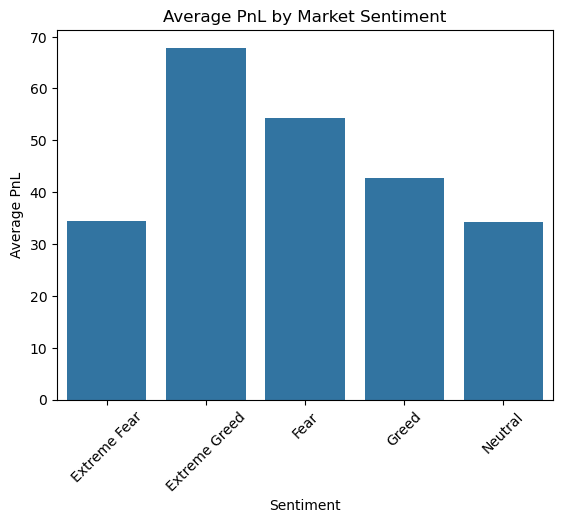

In [59]:
sns.barplot(data=summary, x='Sentiment', y='Average PnL')
plt.title("Average PnL by Market Sentiment")
plt.xticks(rotation=45)
plt.show()


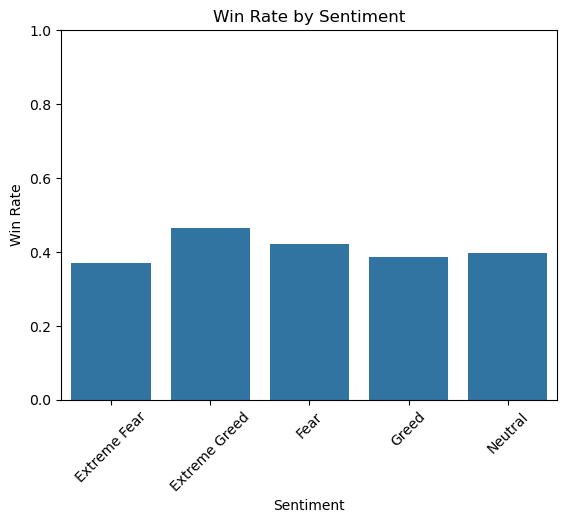

In [37]:
sns.barplot(data=summary, x='Sentiment', y='Win Rate')
plt.title("Win Rate by Sentiment")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()


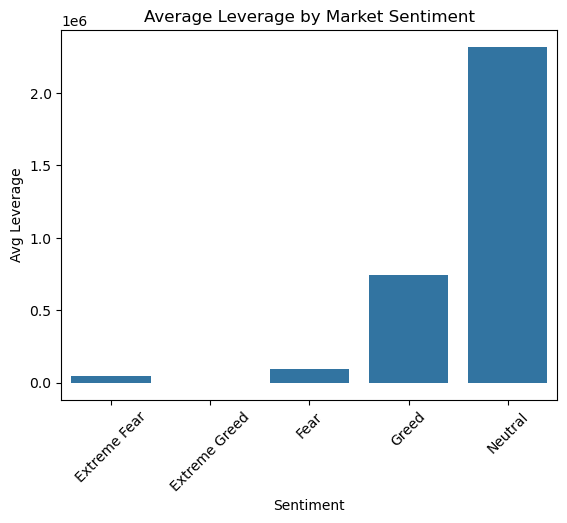

In [60]:
# Group by sentiment
leverage_summary = merged_df.groupby('classification')['leverage'].mean().reset_index()
leverage_summary.columns = ['Sentiment', 'Avg Leverage']

sns.barplot(data=leverage_summary, x='Sentiment', y='Avg Leverage')
plt.title("Average Leverage by Market Sentiment")
plt.xticks(rotation=45)
plt.show()


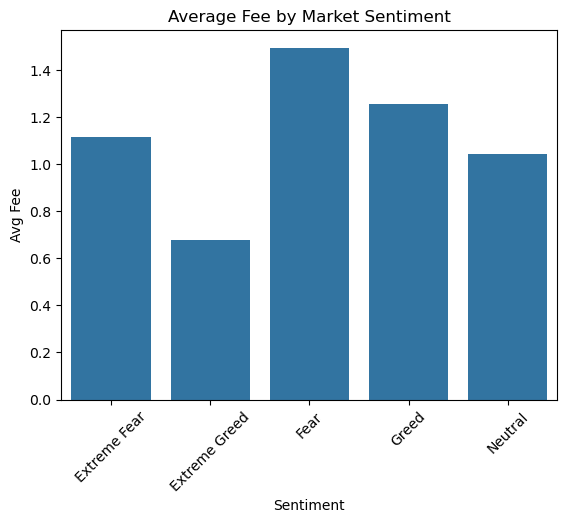

In [61]:
# Group by sentiment and calculate average fee
fee_summary = merged_df.groupby('classification')['fee'].mean().reset_index()
fee_summary.columns = ['Sentiment', 'Avg Fee']

sns.barplot(data=fee_summary, x='Sentiment', y='Avg Fee')
plt.title("Average Fee by Market Sentiment")
plt.xticks(rotation=45)
plt.ylabel("Avg Fee")
plt.xlabel("Sentiment")
plt.show()


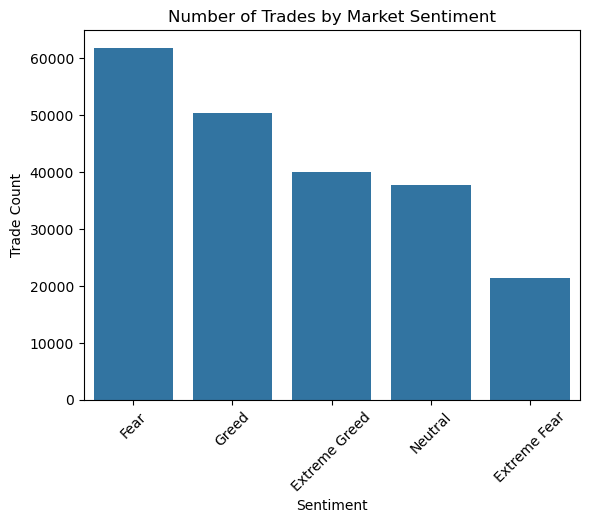

In [63]:
trade_counts = merged_df['classification'].value_counts().reset_index()
trade_counts.columns = ['Sentiment', 'Trade Count']

sns.barplot(data=trade_counts, x='Sentiment', y='Trade Count')
plt.title("Number of Trades by Market Sentiment")
plt.xticks(rotation=45)
plt.show()
